<a href="https://colab.research.google.com/github/surajsarkar/deepLearning/blob/main/notebooks/09_skimlit_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit 📖🔥 

### Check which **GPU** we are using 

In [ ]:
!nvidia-smi -L 

GPU 0: Tesla T4 (UUID: GPU-f489289c-5867-d056-1bad-3607a1789672)


## Get the data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the pubmed_20K folder
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


## Becoming one with the data

In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os 

filepaths = [data_dir + filename for filename in os.listdir(data_dir)]
filepaths

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocessing Data

In [ ]:
# Create function to read the the lines of the document 
def read_file(filepath):
  """
  Reads filename (a text filename) and returns the lines of text as a list
  
  Args:
    filepath: path of the file 
  """
  with open(filepath, "r") as file:
    contents = file.readlines()
    return contents 

In [ ]:
train_lines = read_file(filepaths[1])
train_lines[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [ ]:
train_lines[11]

'###24469619\n'

What will be the data structure of data to process

```python 
[
  {
    'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'Emotional eating is associated with overeating and the development of obesity .'
    'total_lines': 11
  }
]
```

In [ ]:
def preprocess_lines(filepath):

  lines = read_file(filepath)

  same_section_lines = []
  formated_lines = []
  for line in lines:
    if line.startswith("###"):
      same_section_lines = []
    
    elif line.startswith("\n"):

      for index, sentence in enumerate(same_section_lines):
        target, text = sentence.split('\t')
        formated_lines.append({
            "line_number": index,
            "target": target,
            "text": text,
            "total_lines": len(same_section_lines) - 1
        })
    else: 
      same_section_lines.append(line)
  

  return formated_lines



In [ ]:
%%time 
formated_train_lines = preprocess_lines(data_dir + "train.txt")
formated_validation_lines = preprocess_lines(data_dir + "dev.txt")
formated_test_lines = preprocess_lines(data_dir + "test.txt")
print(len(formated_train_lines), len(formated_validation_lines), len(formated_test_lines))

180040 30212 30135
CPU times: user 274 ms, sys: 79.9 ms, total: 354 ms
Wall time: 355 ms


### Convert our data to dataframe and visualise it 

In [ ]:
import pandas as pd

train_df = pd.DataFrame(formated_train_lines)
val_df = pd.DataFrame(formated_validation_lines)
test_df = pd.DataFrame(formated_test_lines)

train_df.head(10)

,line_number,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11
5,5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",11
6,6,RESULTS,There was a clinically relevant reduction in t...,11
7,7,RESULTS,The mean difference between treatment arms ( @...,11
8,8,RESULTS,"Further , there was a clinically relevant redu...",11
9,9,RESULTS,These differences remained significant at @ we...,11


In [ ]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

## Make Numerical Labels (ML model require numerical labels)

In [ ]:
import sklearn 
print(sklearn.__version__)

1.0.2


In [ ]:
train_sentences = train_df["text"]
val_sentences = val_df["text"]
test_sentences = test_df["text"]

In [ ]:
# One Hot Encode the labels 
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_oen_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [ ]:
train_df["target"].to_numpy().reshape(-1, 1).shape

(180040, 1)

In [ ]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [ ]:
# Extract label ("target" columns) and encode them into int 
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(y=train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(y=val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(y=test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
train_labels_encoded.shape

(180040,)

In [ ]:
# Get the classnames and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
# Get helper function 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-25 20:16:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-25 20:16:14 (90.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

## Create a baseline

* Use **Pipeline**
* Create a **tfidf** vectorizer
* Create a **MultinomialNB** layer

### Baseline Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a model 
model_0 = Pipeline([
  ("tfidf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])
# Fit a model 
model_0.fit(X=train_df["text"], y=train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the model 
model_0_evaluation = model_0.score(X=val_df["text"], y=val_labels_encoded)

In [ ]:
model_0_evaluation

0.7218323844829869

In [ ]:
model_0_preds = model_0.predict(X=val_sentences)


In [ ]:
model_0_result = calculate_results(y_true=val_labels_encoded, y_pred=model_0_preds) 
model_0_result

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Create **Vectorizar** for our modelling 

In [ ]:
# Create a text vectorization layer
import tensorflow as tf 
from tensorflow.keras.layers import TextVectorization

text_vectorizar = TextVectorization(
    max_tokens = 68000,
    standardize = "lower_and_strip_punctuation",
    split = "whitespace",
    output_sequence_length = 55,
    pad_to_max_tokens = True
)

In [ ]:
text_vectorizar.adapt(train_sentences)

In [ ]:
rct_20k_vocab_length = len(text_vectorizar.get_vocabulary())
rct_20k_vocab_length

64841

In [ ]:
text_vectorizar.get_config()

{'batch_input_shape': (None, None),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## Create custom **Embedding** for our model 

In [ ]:
from tensorflow.keras.layers import Embedding

embedding = Embedding(
    input_dim = rct_20k_vocab_length,
    output_dim = 128,
    mask_zero=True
)

## Creating test dataset (to make sure data loads faster)

In [ ]:
# Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_oen_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset and turn them into prefetched dataset
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = valid_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Create our first deep model 

### Model 1

In [ ]:
# create model with functional api
import tensorflow as tf


# 1. Create a model 

# Input layer 
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
# Vectorizar layer 
x = text_vectorizar(inputs)
# Embedding layer
x = embedding(x)
# Conv1D layer 
x = tf.keras.layers.Conv1D(64, kernel_size=5, activation="relu", name="conv1d")(x)
# GlobalMaxPollingMax layer
x = tf.keras.layers.GlobalMaxPool1D(name="max_polling")(x)
# output layer 
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
# make a model 
model_1 = tf.keras.Model(inputs, outputs)


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 51, 64)            41024     
                                                                 
 max_polling (GlobalMaxPooli  (None, 64)               0         
 ng1D)                                                           
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# 2. Compile a model 
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
# 3. Fit the model 
model_1.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    validation_data=valid_dataset,
    validation_steps = int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 17s 9ms/step - loss: 0.8398 - accuracy: 0.6805 - val_loss: 0.5948 - val_accuracy: 0.7829
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.5836 - accuracy: 0.7854 - val_loss: 0.5462 - val_accuracy: 0.7919
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.5471 - accuracy: 0.7994 - val_loss: 0.5249 - val_accuracy: 0.8029


In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)

In [ ]:
model_1_pred_probs.shape

(30212, 5)

In [ ]:
model_1_pred_probs[0], model_1_pred_probs[0].shape

(array([0.50148916, 0.1170818 , 0.00605166, 0.36973554, 0.00564179],
       dtype=float32), (5,))

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

In [ ]:
val_labels_encoded[:3]

array([0, 0, 3])

In [ ]:
model_1_result = calculate_results(y_true=val_labels_encoded, y_pred=model_1_preds)
model_1_result

{'accuracy': 80.32569839798755,
 'f1': 0.8015848640469813,
 'precision': 0.8013383563588226,
 'recall': 0.8032569839798755}

In [ ]:
model_0_result

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [ ]:
# funciton for preds and pred probs
def give_preds(model, data, y_true):
  model_pred_probs = model.predict(data)
  model_preds = tf.argmax(model_pred_probs, axis=1)
  model_result = calculate_results(y_true=y_true, y_pred=model_preds)

  return model_pred_probs, model_preds, model_result

In [ ]:
model_1_pred_probs, model_1_preds, model_1_result = give_preds(model_1, val_sentences, val_labels_encoded)
model_1_pred_probs[:2], model_1_preds[:2], model_1_result

(array([[5.0148916e-01, 1.1708180e-01, 6.0516614e-03, 3.6973554e-01,
         5.6417882e-03],
        [2.1956192e-01, 6.5486115e-01, 3.7240569e-04, 1.2360008e-01,
         1.6044143e-03]], dtype=float32),
 <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>,
 {'accuracy': 80.32569839798755,
  'f1': 0.8015848640469813,
  'precision': 0.8013383563588226,
  'recall': 0.8032569839798755})

In [ ]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Feature extractor model with **Universal Sentence Encoder** from tensorflow hub

### Model 2

In [ ]:
import tensorflow_hub as hub

# create a keras layer for of feature extractor
extractor_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable=False,
                                 input_shape=[],
                                 dtype=tf.string,
                                 name="use")

# Create model with functional api
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = extractor_layer(inputs)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_universal_sentence_encoder")


In [ ]:
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
history_2 = model_2.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1*len(train_dataset)),
    validation_data=valid_dataset,
    validation_steps=int(0.1*len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 11s 14ms/step - loss: 0.9171 - accuracy: 0.6481 - val_loss: 0.7979 - val_accuracy: 0.6872
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7717 - accuracy: 0.7006 - val_loss: 0.7553 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7534 - accuracy: 0.7127 - val_loss: 0.7405 - val_accuracy: 0.7118


In [ ]:
model_2_pred_probs, model_2_preds, model_2_result = give_preds(model_2, val_sentences, val_labels_encoded)
model_2_result

{'accuracy': 71.36568251026083,
 'f1': 0.7113799004819116,
 'precision': 0.7149813841271493,
 'recall': 0.7136568251026082}

### Model 2 seq

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
extractor_layer_seq = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    input_shape=[],
    dtype=tf.string,
    name="use_seq"
)

model_2_seq = tf.keras.Sequential([
  extractor_layer_seq,
  # tf.keras.layers.GlobalMaxPool1D(),
  tf.keras.layers.Dense(5, activation="softmax")
])


In [ ]:
model_2_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 use_seq (KerasLayer)        (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 256,800,389
Trainable params: 2,565
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2_seq.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_2_seq.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1*len(train_dataset)),
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 11s 14ms/step - loss: 1.2627 - accuracy: 0.5366 - val_loss: 1.0893 - val_accuracy: 0.6021
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 1.0149 - accuracy: 0.6241 - val_loss: 0.9591 - val_accuracy: 0.6443
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.9338 - accuracy: 0.6588 - val_loss: 0.8997 - val_accuracy: 0.6669


In [ ]:
model_2_seq_pred_probs, model_2_seq_preds, model_2_seq_result = give_preds(model_2_seq,
                                                                           val_sentences,
                                                                           val_labels_encoded)

model_2_seq_result

{'accuracy': 67.25142327551966,
 'f1': 0.6571773040951844,
 'precision': 0.6684206077777337,
 'recall': 0.6725142327551966}

## Make Character embedding 

In [ ]:
# Make function to split sentences in character lavel
def split_chars(text):
  return  " ".join(list(text))

In [ ]:
import random 
random_train_sentence = random.choice(train_sentences)

split_chars(random_train_sentence)

'F u r t h e r m o r e   ,   t h e   s a f e t y   a n d   e f f i c a c y   r e s u l t s   o f   p r e v i o u s   t r i a l s   a r e   n o w   c o n f i r m e d   i n   a   l a r g e r   s t u d y   p o p u l a t i o n   . \n'

In [ ]:
# Split sententence-lavel data split to data character-lavel data split
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   . \n',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   . \n',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e 

In [ ]:
# Check the average length of the character in sentence
char_lens = [len(sentence) for sentence in train_sentences]
char_lens_avg = sum(char_lens)/len(char_lens)
print(char_lens_avg)

150.3662574983337


(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([   2.        ,  199.85714286,  397.71428571,  595.57142857,
         793.42857143,  991.28571429, 1189.14285714, 1387.        ]),
 <a list of 7 Patch objects>)

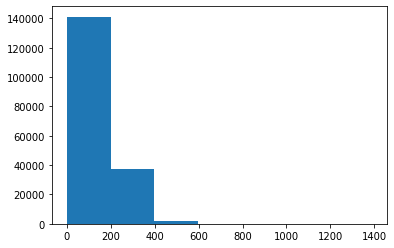

In [ ]:
# check the distribution of the sentences 
import matplotlib.pyplot as plt

plt.hist(char_lens, bins=7)

In [ ]:
# Find what length of character covers 95% of the sentence length
import numpy as np

out_seq_char_len = int(np.percentile(char_lens, 95))
out_seq_char_len

291

In [ ]:
# Get all keyboard characters 
import string 

alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [ ]:
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-lavel token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2

import tensorflow as tf

char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=out_seq_char_len,
    name="char_vectorizer"
)

In [ ]:
# Adapt character vectorizer to the tarining character
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
char_vocab_length = len(char_vocab)

In [ ]:
# Let's see what out vectorizer does 
random_train_char = random.choice(train_chars)
print(f"Random Train Character\n{random_train_char}")
print(f"Length of the Char:\n\n {len(random_train_char.split())}\n")
vectorized_chars = char_vectorizer([random_train_char])
print(f"Vectorized Chars\n\n{vectorized_chars}")

Random Train Character
T h e r e   w e r e   s i g n i f i c a n t l y   m o r e   a c u t e   r e j e c t i o n s   (   a l l   d e f i n i t i o n s   )   i n   p a t i e n t s   w i t h   M P A   A U C   l e v e l s   <   @ m g h / l   c o m p a r e d   w i t h   t h o s e   w i t h   M P A   A U C   l e v e l s   @ m g h / l   w i t h i n   @ m o n t h s   (   p   <   @   )   . 

Length of the Char:

 148

Vectorized Chars

[[ 3 13  2  8  2 20  2  8  2  9  4 18  6  4 17  4 11  5  6  3 12 19 15  7
   8  2  5 11 16  3  2  8  2 27  2 11  3  4  7  6  9  5 12 12 10  2 17  4
   6  4  3  4  7  6  9  4  6 14  5  3  4  2  6  3  9 20  4  3 13 15 14  5
   5 16 11 12  2 21  2 12  9 15 18 13 12 11  7 15 14  5  8  2 10 20  4  3
  13  3 13  7  9  2 20  4  3 13 15 14  5  5 16 11 12  2 21  2 12  9 15 18
  13 12 20  4  3 13  4  6 15  7  6  3 13  9 14  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## Character lavel embedding

In [ ]:
import tensorflow as tf

char_embedding = tf.keras.layers.Embedding(
    input_dim=char_vocab_length,
    output_dim=25,
    mask_zero = True
)

In [ ]:
char_embedding(char_vectorizer([train_chars[0]]))

<tf.Tensor: shape=(1, 291, 25), dtype=float32, numpy=
array([[[ 0.00386304, -0.01841008, -0.03040995, ..., -0.02250613,
          0.01507229,  0.03838238],
        [-0.01539123, -0.04001693, -0.01223264, ..., -0.01404671,
         -0.04291099, -0.02577149],
        [-0.03610691,  0.04800725, -0.00148942, ..., -0.04500948,
          0.01846904, -0.01195457],
        ...,
        [-0.0116782 , -0.01743187, -0.03693678, ...,  0.02367783,
          0.04587609, -0.03070258],
        [-0.0116782 , -0.01743187, -0.03693678, ...,  0.02367783,
          0.04587609, -0.03070258],
        [-0.0116782 , -0.01743187, -0.03693678, ...,  0.02367783,
          0.04587609, -0.03070258]]], dtype=float32)>

## Model 3 Conv1D Model

In [ ]:
char_train_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
char_val_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_oen_hot))
char_test_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

char_train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
char_train_dataset = char_train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
char_val_dataset = char_val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
char_test_dataset = char_test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

len(char_train_dataset)

5627

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(64, kernel_size=5, activation="relu")(x)
# x = layers.Dense(64, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

In [ ]:
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 291)              0         
 ization)                                                        
                                                                 
 embedding_1 (Embedding)     (None, 291, 25)           700       
                                                                 
 conv1d (Conv1D)             (None, 287, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 5)                 325 

In [ ]:
model_3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
model_3.fit(
    char_train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(char_train_dataset)),
    validation_data=char_val_dataset, 
    validation_steps=int(0.1 * len(char_val_dataset))
)

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2807 - accuracy: 0.4795 - val_loss: 1.0724 - val_accuracy: 0.5715
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0200 - accuracy: 0.5946 - val_loss: 0.9569 - val_accuracy: 0.6247
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9354 - accuracy: 0.6302 - val_loss: 0.8799 - val_accuracy: 0.6609


In [ ]:
model_3_pred_probs, model_3_preds, model_3_result = give_preds(model_3, char_val_dataset, val_labels_encoded)
model_3_result

{'accuracy': 65.3018668078909,
 'f1': 0.6409043949525455,
 'precision': 0.6467056329423324,
 'recall': 0.6530186680789091}

## Model 4 : concatenate two different model

* Create a token lavel embedding model similar to `modle_1`
* Create a chareacter lavel embedding similar to `model_3`
* Combine the above two with a concatenate layer `layers.Concatenate`
* Build a series of output layers 
* Create a model which takes both **character** and **word** sequence as an input


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# 1. setup token input/model
token_input = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embedding = extractor_layer(token_input)
token_output = layers.Dense(128, activation="relu", name="token_output")(token_embedding)
token_model = tf.keras.Model(inputs=token_input, outputs=token_output)

# 2. setup char input/model
char_input = layers.Input(shape=(1,), dtype=tf.string)
char_vector = char_vectorizer(char_input)
char_embed = char_embedding(char_vector)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = tf.keras.Model(inputs=char_input, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concatenate = layers.Concatenate(name="token_char_concatenate")([token_model.output,
                                                                            char_model.output])

# 4. create output layer - adding dropout
combined_dropout = layers.Dropout(0.5)(token_char_concatenate)
conbined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(conbined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)


# 5. Construct model with char and token embeddings 
model_4 = tf.keras.Model(inputs=[token_model.inputs, char_model.inputs], outputs=output_layer, name="model_4")



In [ ]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 291)         0           ['input_4[0][0]']                
 tion)                                                                                            
                                                                                                  
 use (KerasLayer)               (None, 512)          256797824   ['token_input[0][0]']      

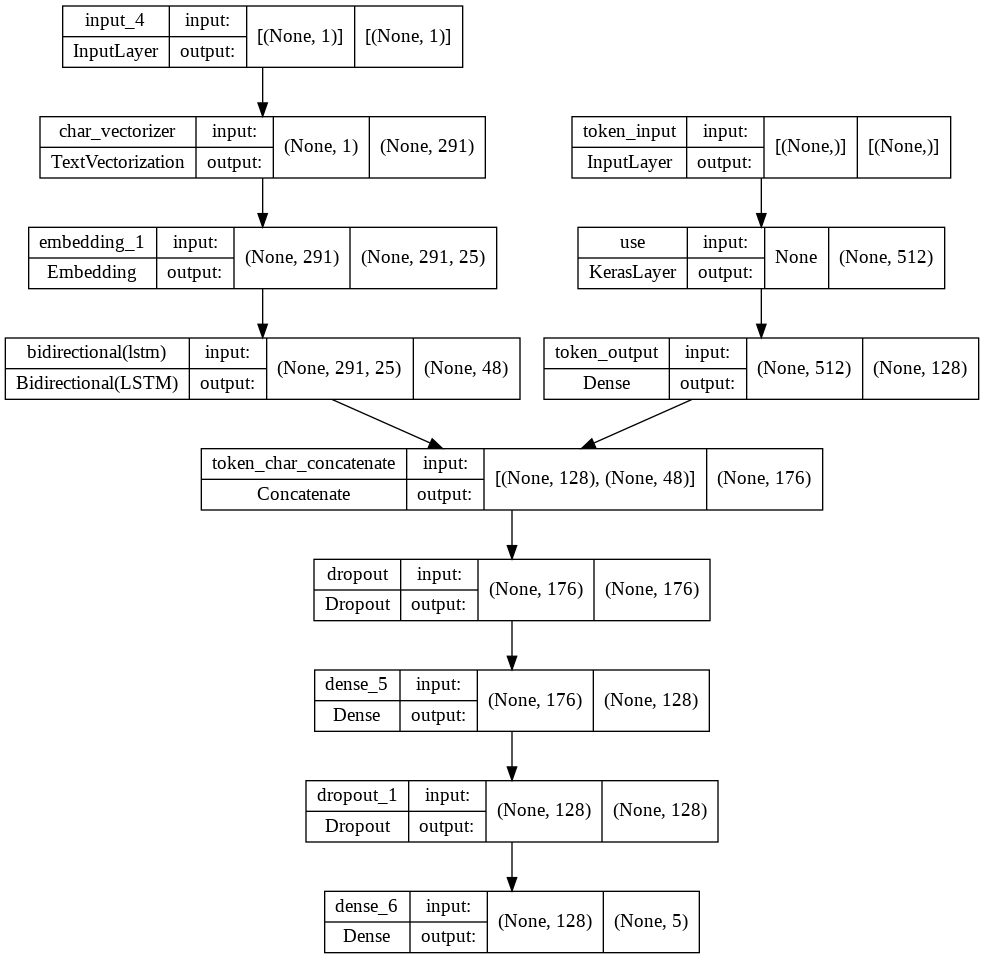

In [ ]:
# Plot hybrid token and character model 
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model 
model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

### Make a efficient data pipeline

In [ ]:
# make performent dataset 

# Train char token data
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# batch and prefetch data 
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# Val char token data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_oen_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# batch and prefetch data 
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Train char token data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

# batch and prefetch data 
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting **Model 4** : Model with token and character lavel embedding 

In [ ]:
model_4.fit(
    train_char_token_dataset,
    steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
    epochs=3,
    validation_data=val_char_token_dataset,
    validation_steps=int(0.1 * len(val_char_token_dataset))
)

Epoch 1/3
562/562 [==============================] - 39s 54ms/step - loss: 0.9833 - accuracy: 0.6019 - val_loss: 0.7878 - val_accuracy: 0.6865
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.8051 - accuracy: 0.6879 - val_loss: 0.7136 - val_accuracy: 0.7311
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.7802 - accuracy: 0.7023 - val_loss: 0.6939 - val_accuracy: 0.7407


In [ ]:
len(val_char_token_dataset), len(val_char_token_data)

(945, 30212)

In [ ]:
model_4_pred_probs, model_4_preds, model_4_result = give_preds(
    model_4, val_char_token_dataset, val_labels_encoded
)

In [ ]:
model_4_result

{'accuracy': 73.15636171057858,
 'f1': 0.7290949425994024,
 'precision': 0.7307527541252665,
 'recall': 0.7315636171057858}

In [ ]:
print("hello_world")

hello_world


## Create Positional Embeddings

In [ ]:
 train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

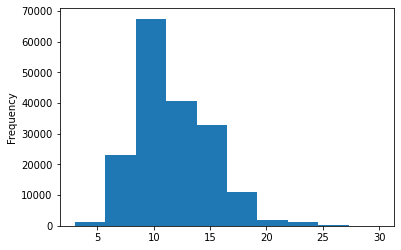

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
# Use tensorflow to one hot encode tensors of our 'one hot encode' line numbers of train df
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_number_one_hot[:5], train_line_number_one_hot.shape


(<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [ ]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

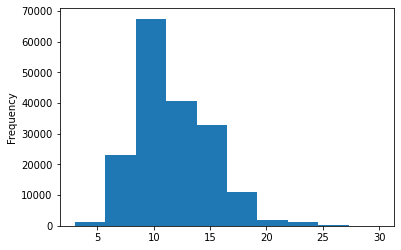

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
# Use tensorflow to one hot encode tensors of total lines 
train_total_line_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_line_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_line_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [ ]:
train_total_line_one_hot[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11


In [ ]:
train_df.tail()

,line_number,target,text,total_lines
180035,7,RESULTS,For the absolute change in percent atheroma vo...,11
180036,8,RESULTS,"For PAV , a significantly greater percentage o...",11
180037,9,RESULTS,Both strategies had acceptable side effect pro...,11
180038,10,CONCLUSIONS,"Compared with standard statin monotherapy , th...",11
180039,11,CONCLUSIONS,( Plaque Regression With Cholesterol Absorptio...,11


## **Model 5** : Pretrained model with token embedding + character embedding + positional embedding 


Creating a tribred embedding model:
1. Create a token-lavel model 
2. Create a character-lavel model
3. Create a model for **line-number** feature
4. Create a model for **total-lines** feature
5. Combine the output of **1** & **2** using `tf.keras.layers.Concatenate`
6. Combine the output of **3**, **4**, **5** using `tf.keras.layers.Concatenate`
7. Create a output layer to accept the tribed embedding and output label probabilities.
8. Combine the inputs of **1, 2, 3, 4** and **outputs** into `tf.keras.Model` to create a model.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
# 1. Create a token embedding input/model
model_5_token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
model_5_token_embedding = extractor_layer(model_5_token_inputs)
model_5_outputs = layers.Dense(128, activation="relu", name="dense_output")(model_5_token_embedding)
model_5_token = tf.keras.Model(inputs=model_5_token_inputs, outputs=model_5_outputs)

# 2. Create a char lavel embedding 
model_5_char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
model_5_char_vector = char_vectorizer(model_5_char_inputs)
model_5_char_embedding = char_embedding(model_5_char_vector)
model_5_bi_lstm = layers.Bidirectional(layers.LSTM(24), name="model_5_bi_lstm")(model_5_char_embedding)
model_5_char = tf.keras.Model(
    inputs=model_5_char_inputs,
    outputs=model_5_bi_lstm
)

# 3. Create a line no inputs/model 
line_no_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_no_inputs")
line_no_outputs = layers.Dense(32, activation="relu")(line_no_inputs)
line_no_model = tf.keras.Model(line_no_inputs, line_no_outputs)

# 4. Create a total-lines inputs/model 
total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_line_inputs")
total_line_outputs = layers.Dense(32, activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(inputs=total_line_inputs, outputs=total_line_outputs)

# 5. Combine the output of 1 & 2 using tf.keras.layers.Concatenate.
combined_embeddings = tf.keras.layers.Concatenate(name="m5_token_char_concatenate")([model_5_token.output,
                                                                                model_5_char.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(combined_embeddings)

# 6. Combine the output of 3, 4, 5 using tf.keras.layers.Concatenate.
tribrid_embeddings = layers.Concatenate(name="line_no_total_line_5_con")([
  line_no_model.output,
  total_line_model.output,
  z
])

# 7. Create a output layer to accept the tribed embedding and output label probabilities.
model_5_outputs = layers.Dense(5, activation="softmax")(tribrid_embeddings)

# 8. Combine the inputs of 1, 2, 3, 4 and outputs into tf.keras.Model to create a model.
model_5 = tf.keras.Model(inputs=[line_no_model.input,
                                 total_line_model.input,
                                 model_5_token.input,
                                 model_5_char.input],
                         outputs=model_5_outputs,
                         name="model_5_tribed_cmbedding_model")

In [ ]:
model_5.summary()

Model: "model_5_tribed_cmbedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 291)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 use (KerasLayer)               (None, 512)          256797824   ['to

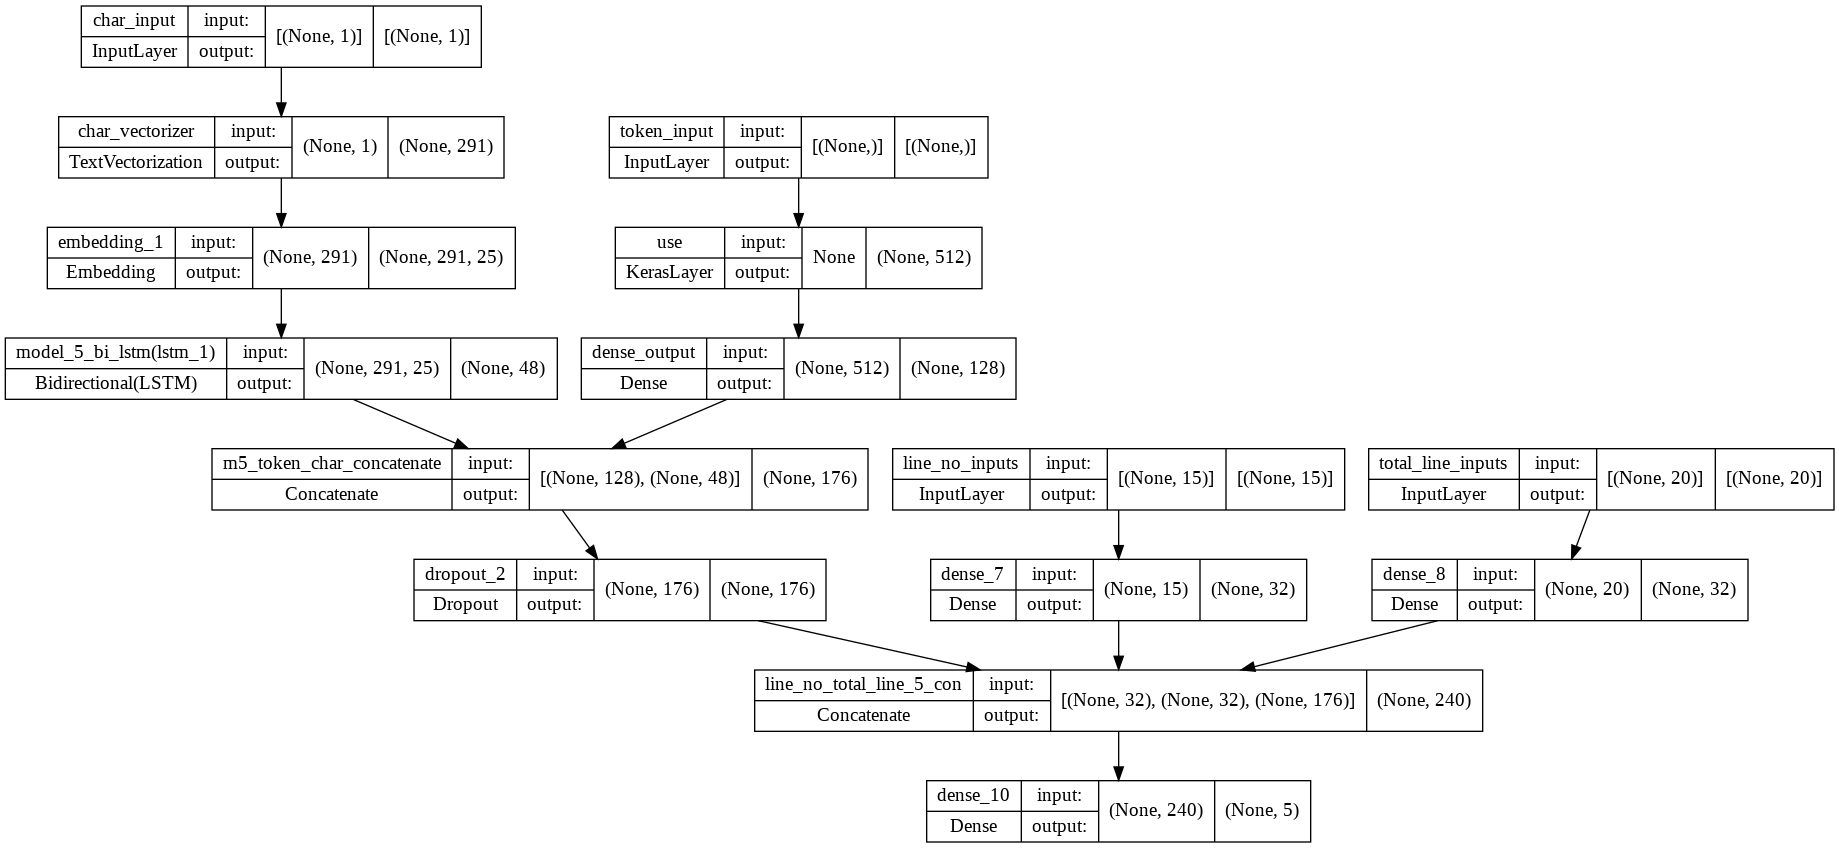

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

## Compiling my biggest model I have built so far(DATE=23/July/2022), So excited about this huh huh 😃😃🕺🏽🕺🏽

In [ ]:
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

### Preparing data for my biggest model for performance

Sequence of the data should be:

* ⬇️ line number
* ⬇️ total lines
* ⬇️ token input
* ➡️ char input


In [ ]:
model_5_train_data = tf.data.Dataset.from_tensor_slices((
    train_line_number_one_hot,
    train_total_line_one_hot,
    train_sentences, 
    train_chars
))
model_5_train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_pos_dataset = tf.data.Dataset.zip((model_5_train_data, model_5_train_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
model_5_val_data = tf.data.Dataset.from_tensor_slices((
    val_line_number_one_hot,
    val_total_line_one_hot,
    val_sentences,
    val_chars
))

model_5_val_labels = tf.data.Dataset.from_tensor_slices(val_labels_oen_hot)

val_char_token_pos_dataset = tf.data.Dataset.zip((model_5_val_data, model_5_val_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_char_token_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
val_char_token_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Fitting , evaluating, and making prediction from our biggest model yet

In [ ]:
model_5.fit(
    train_char_token_pos_dataset,
    epochs=3, 
    steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
    validation_data=val_char_token_pos_dataset,
    validation_steps=int(0.1 * len(val_char_token_pos_dataset))
)

Epoch 1/3
562/562 [==============================] - 38s 54ms/step - loss: 1.1270 - accuracy: 0.7074 - val_loss: 0.9962 - val_accuracy: 0.7975
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9891 - accuracy: 0.7999 - val_loss: 0.9654 - val_accuracy: 0.8168
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9724 - accuracy: 0.8111 - val_loss: 0.9596 - val_accuracy: 0.8185


In [ ]:
model_5_pred_probs, model_5_preds, model_5_result = give_preds(model_5, 
                                                               val_char_token_pos_dataset,
                                                               val_labels_encoded)
model_5_result

{'accuracy': 81.94757050178737,
 'f1': 0.8182373760153039,
 'precision': 0.8176227323755226,
 'recall': 0.8194757050178737}

In [ ]:
model_1_result

{'accuracy': 80.32569839798755,
 'f1': 0.8015848640469813,
 'precision': 0.8013383563588226,
 'recall': 0.8032569839798755}

In [ ]:
model_4_result

{'accuracy': 73.15636171057858,
 'f1': 0.7290949425994024,
 'precision': 0.7307527541252665,
 'recall': 0.7315636171057858}

## Compare model results

In [ ]:
import pandas as pd

all_model_result = pd.DataFrame({"model_0": model_0_result,
                                 "model_1": model_1_result,
                                 "model_2": model_2_result,
                                 "model_3": model_3_result,
                                 "model_4": model_4_result,
                                 "model_5": model_5_result})

all_model_result = all_model_result.transpose()
all_model_result["accuracy"] = all_model_result["accuracy"]/100
all_model_result

,accuracy,precision,recall,f1
model_0,0.721832,0.718647,0.721832,0.698925
model_1,0.803257,0.801338,0.803257,0.801585
model_2,0.713657,0.714981,0.713657,0.711380
model_3,0.653019,0.646706,0.653019,0.640904
model_4,0.731564,0.730753,0.731564,0.729095
model_5,0.819476,0.817623,0.819476,0.818237


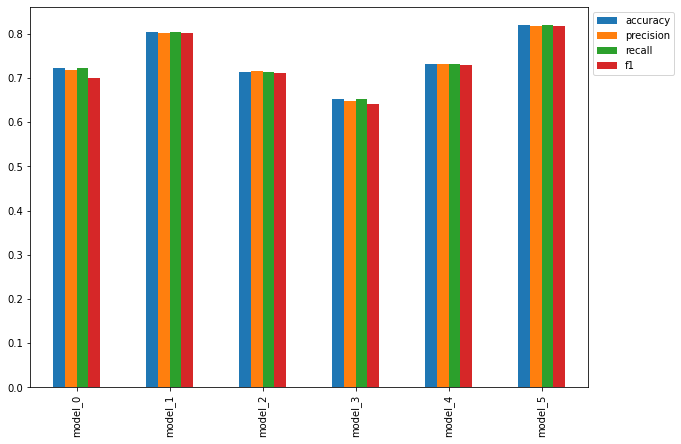

In [ ]:
all_model_result.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

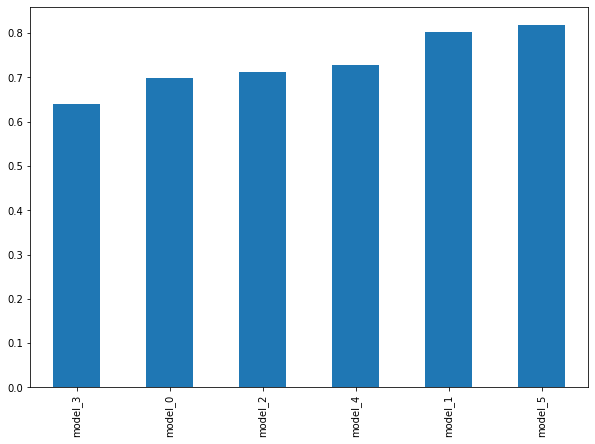

In [ ]:
# Plotting precision score in ascending order 
all_model_result.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7))

## Save and load our best Model 

In [ ]:
# saving model 5 
model_5.save("skimlit")

In [ ]:
loaded_model = tf.keras.models.load_model("skimlit")

In [ ]:
loded_model_pred_probs, loaded_model_preds, loaded_model_result = give_preds(loaded_model,
                                                                             val_char_token_pos_dataset,
                                                                             val_labels_encoded)

In [ ]:
loaded_model_result

{'accuracy': 81.94757050178737,
 'f1': 0.8182373760153039,
 'precision': 0.8176227323755226,
 'recall': 0.8194757050178737}

## Download and load a pretrained model from goggle storage

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2022-07-25 20:14:31--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 2404:6800:4003:c11::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M  55.1MB/s    in 19s     

2022-07-25 20:14:50 (49.5 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/

In [ ]:
# load the downloaded model from google storage
import tensorflow as tf
gs_loaded_model = tf.keras.models.load_model("skimlit_gs_model/skimlit_tribrid_model/")

In [ ]:
_, _, gs_model_result = give_preds(gs_loaded_model,
                                   val_char_token_pos_dataset,
                                   val_labels_encoded)
gs_model_result

## Creating model 6
* Conv1D token embedding
* Char embedding 
* line no 
* total lines 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# 1. Conv1D token embedding

c_inputs = layers.Input(shape=(1,), dtype=tf.string)
c_text_vectorizer = text_vectorizar(c_inputs)
c_embedding = token_embedding(c_text_vectorizer)
conv_1_d = layers.Conv1D(64, kernel_size=3, name="conv_token")(c_embedding)
max_pool = layers.GlobalMaxPool1D()(conv_1_d)
outputs = layers.Dense(32, activation="relu")(max_pool)
c_model = tf.keras.Model(c_inputs, outputs)

# 2. setup char input/model
char_input = layers.Input(shape=(1,), dtype=tf.string)
char_vector = char_vectorizer(char_input)
char_embed = char_embedding(char_vector)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = tf.keras.Model(inputs=char_input, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concatenate = layers.Concatenate(name="token_char_concatenate")([token_model.output,
                                                                            char_model.output])

# 4. create output layer - adding dropout
combined_dropout = layers.Dropout(0.5)(token_char_concatenate)
conbined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(conbined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)


# 5. Construct model with char and token embeddings 
model_5 = tf.keras.Model(inputs=[token_model.inputs, char_model.inputs], outputs=output_layer, name="model_4")
